In [1]:
import pandas as pd
import sqlite3
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tqdm

In [2]:
conn = sqlite3.connect('database.db')

c = conn.cursor()

In [5]:
size = [] # number of people in coalition
motions = [] # number of motions per day

starting_date = dt.date(2004,11,1)
final_date = dt.date(2023,12,15)
no_days = (final_date - starting_date).days

for i in tqdm.tqdm(range(no_days+1)):
    
    date = starting_date + dt.timedelta(days = i)

    dstr = date.isoformat()
    
    c.execute("""
    SELECT COUNT(DISTINCT Fractions.MP_id) FROM Fractions
    INNER JOIN Coalitions
    ON Fractions.Fraction = Coalitions.Fraction
    INNER JOIN MPs
    ON MPs.MP_id = Fractions.MP_id
    WHERE Fractions.Date_from <= ?
    AND Fractions.Date_to >= ?
    AND Coalitions.Date_from <= ?
    AND Coalitions.Date_to >= ?
    """, (dstr, dstr, dstr, dstr))

    size.append(c.fetchall()[0][0])

    c.execute("""
    SELECT COUNT(DISTINCT Motion_id) FROM Motions
    WHERE Date = ?""", (dstr,))

    motions.append(c.fetchall()[0][0])


100%|██████████████████████████████████████████████████████████████████████████████| 6984/6984 [08:55<00:00, 13.04it/s]


(array([10957., 12418., 13879., 15340., 16801., 18262., 19723.]),
 [Text(10957.0, 0, '2000'),
  Text(12418.0, 0, '2004'),
  Text(13879.0, 0, '2008'),
  Text(15340.0, 0, '2012'),
  Text(16801.0, 0, '2016'),
  Text(18262.0, 0, '2020'),
  Text(19723.0, 0, '2024')])

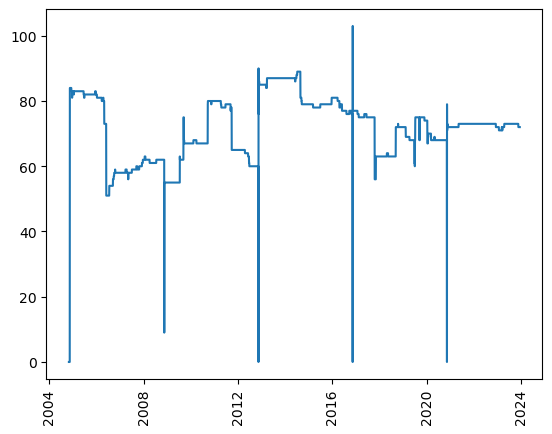

In [6]:
left = 0
right = len(motions)
dates = [dt.date(2004,11,1) + dt.timedelta(days = i) for i in range(left,right)]
#dates = range(left,right)
plt.plot(dates, size[left:right])
#plt.plot(dates, motions[left:right])
plt.xticks(rotation = 90)

In [7]:
def calc_unity_score(votes):

    # simplest version first: what fraction of the coalition did the same thing as the majority of the coalition
    count = {
        1: 0,
        0: 0,
        -1: 0
    }
    for vote in votes:
        if vote[0] is not None:
            count[vote[0]] += 1
    
    if sum(count.values()) == 0:
        return 0
    print(count)
    return max(count.values()) / sum(count.values())
    
def daily_unity(date):

    c.execute("""
    SELECT DISTINCT Motion_id FROM Motions
    WHERE Date = ?""", (date,))

    motion_ids = [item[0] for item in c.fetchall()]
    scores = []

    for motion_id in motion_ids:

        c.execute("""
        SELECT Vote FROM Votes
        INNER JOIN Motions
        ON Votes.Motion_id = Motions.Motion_id
        INNER JOIN Fractions
        ON Votes.MP_id = Fractions.MP_id
        INNER JOIN Coalitions
        ON Fractions.Fraction = Coalitions.Fraction
        WHERE Coalitions.Date_from <= ?
        AND Coalitions.Date_to >= ?
        AND Fractions.Date_from <= ?
        AND Fractions.Date_to >= ?
        AND Motions.Motion_id = ?""", (date, date, date, date, motion_id))

        score = calc_unity_score(c.fetchall())
        if score != 0:
            scores.append(score)

    if len(scores) == 0:
        return 0,0
    avg_score = sum(scores) / len(scores)
    return avg_score, len(scores)

def unity():

    starting_date = dt.date(2004,11,1)
    final_date = dt.date(2023,12,15)

    no_days = (final_date - starting_date).days
    
    unities = []
    
    for i in tqdm.tqdm(range(no_days+1)):
        date = starting_date + dt.timedelta(days = i)
        avg_score, no_motions = daily_unity(date)
        unities.append({
            'date': date,
            'avg_score': avg_score,
            'no_motions': no_motions
        })
        date = date + dt.timedelta(days = 1)

    return unities



In [14]:
unities = unity()
unities_df = pd.DataFrame(unities)
unities_df.to_csv('data/unities.csv')

100%|████████████████████████████████████████████████████████████████████████████| 6984/6984 [3:41:20<00:00,  1.90s/it]


In [10]:
c.execute("""SELECT DISTINCT Date_from, Date_to, Coalition_id, PM_id, Term_id FROM Coalitions
ORDER BY Coalition_id ASC""")

c_data = c.fetchall()

unities_df = pd.read_csv('new_unities.csv')

unities_df['date'] = pd.to_datetime(unities_df['date'])

bins = [np.datetime64(row[0]) for row in c_data] + [np.datetime64(c_data[-1][1])]

unities_df = unities_df.assign(coalition_id = lambda x: pd.cut(x['date'], bins = bins, include_lowest = True, labels = range(len(bins)-1))) \
                       .fillna(0) \
                       .assign(pm_id = lambda x: pd.Series([c_data[int(i)][3] for i in x['coalition_id']])) \
                       .assign(term_id = lambda x: pd.Series([c_data[int(i)][4] for i in x['coalition_id']])) \
                       .assign(pm_unity = lambda x: x['no_motions'] * x['avg_score']) \
                       .assign(pm_unity = lambda x: x.groupby('pm_id')['pm_unity'].transform('sum')) \
                       .assign(pm_unity = lambda x: x['pm_unity'] / x.groupby('pm_id')['no_motions'].transform("sum")) \
                       .assign(window_unity = lambda x: x['no_motions'] * x['avg_score']) \
                       .assign(window_unity = lambda x: x.groupby('pm_id')['window_unity'].transform(lambda x: x.rolling(window = 100, center = True).sum())) \
                       .assign(window_unity = lambda x: x['window_unity'] / x.groupby('pm_id')['no_motions'].transform(lambda x: x.rolling(window = 100, center = True).sum())) \
                       .assign(coalition_size = size)

def calc_window_unity(df_, window = 100):
    df_ = df_.assign(window_unity = lambda x: x['no_motions'] * x['avg_score']) \
             .assign(window_unity = lambda x: x.groupby('pm_id')[window_unity])

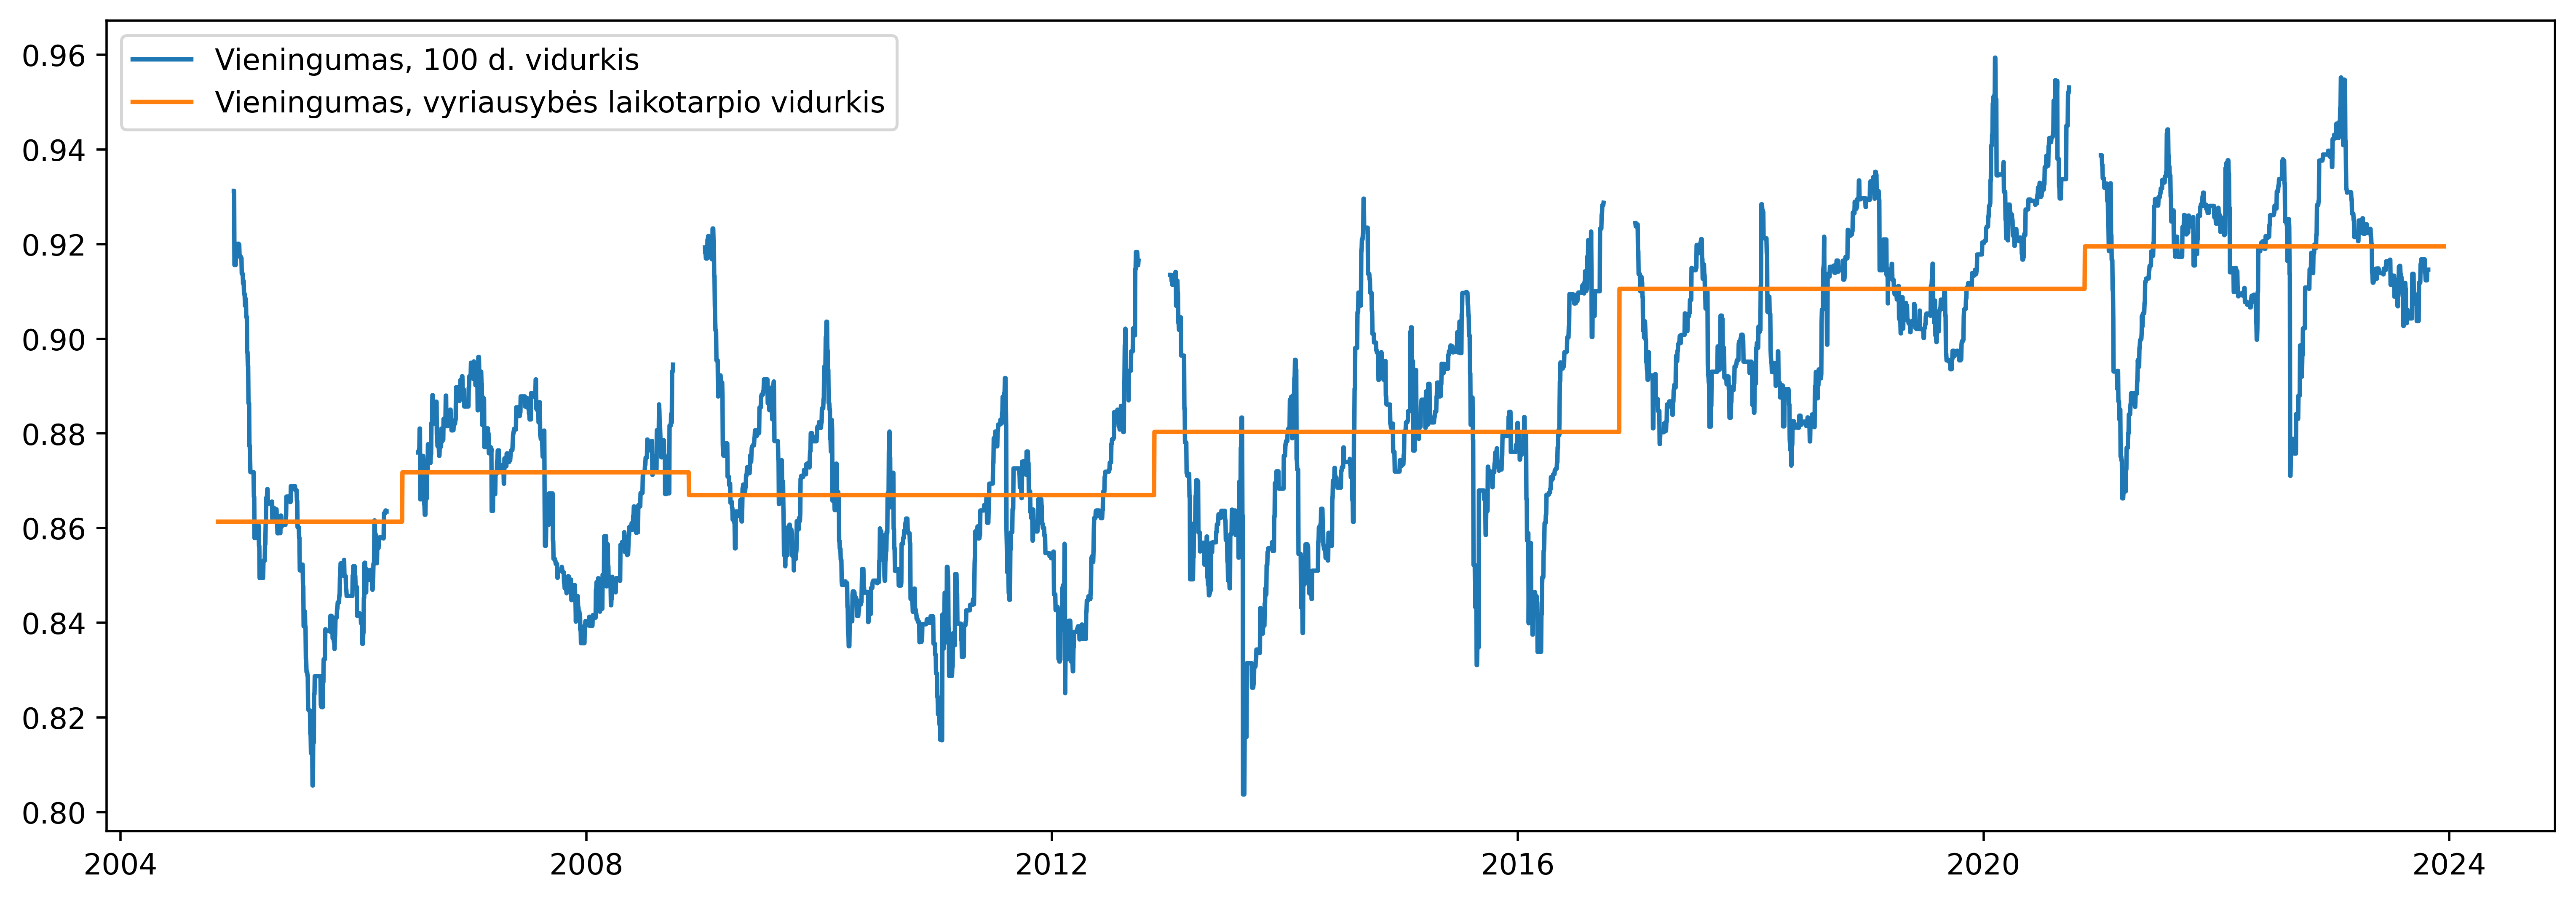

In [26]:
plt.figure(figsize = (15,5), dpi = 500)
plt.plot(unities_df['date'], unities_df['window_unity'], label = 'Vieningumas, 100 d. vidurkis')
plt.plot(unities_df['date'], unities_df['pm_unity'], label = 'Vieningumas, vyriausybės laikotarpio vidurkis')
# plt.plot(unities_df['date'], unities_df['coalition_size'] / unities_df['coalition_size'].max())
plt.legend()
plt.savefig('vieningumas/vieningumas.jpg')